In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path

We are checking how the buffer size affects performance. The main change here is that buffered_fisher_yates uses the fisher_yates_32 algo if the data size is below BUFFER_THRESHOLD.

In [2]:
# A function which can sort dataframes in a list of a dataframes. Based on bubble sort.
def sort_dataframe(dataframes: list, key: str):
    swapped = True
    while (swapped):
        swapped = False
        for i in range(len(dataframes)-1):
            # dataframes[i] gives us the ith dataframe, dataframes[i][key] gives us the right column and 
            # dataframes[i][key][0] gives us the first element of that column. We can do this because 
            # key should be equal for the whole column.
            a = dataframes[i][key][0]
            b = dataframes[i+1][key][0]
            if a > b:
                temp = dataframes[i]
                dataframes[i] = dataframes[i+1]
                dataframes[i+1] = temp
                swapped = True

In [10]:
# We load data
buffered_files = glob.glob(path.join("..", "cpp", "uni-machine", "v0.1.12", "buffered", "*.csv"))
dfs_buffered = [pd.read_csv(f) for f in buffered_files]

In [11]:
# We sort the data
sort_dataframe(dfs_buffered, "buffer")

In [12]:
# We calculate runtime per integer
for df in dfs_buffered:
    df["runtime/integer [ns]"] = df["total_runtime"] / (df["total_runs"] * df["integers"])

Text(0.5, 1.0, 'Comapring buffered_fisher_yates')

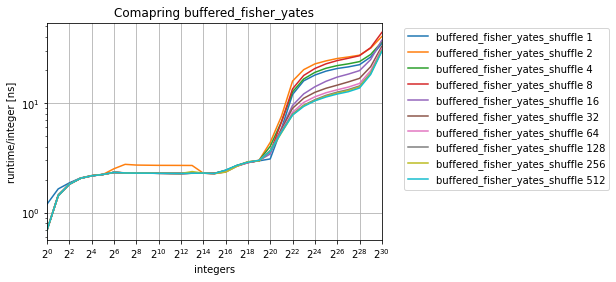

In [18]:
# We plot data
ax_xticks = [2 ** i for i in range(0, 31, 2)]
ax_yticks = [1 * i for i in range(0, 50, 1)]

ax = dfs_buffered[0].plot(x="integers", y="runtime/integer [ns]", label=dfs_buffered[0]["function"][0] + " " + str(dfs_buffered[0]["buffer"][0]))
for i in range(1, len(dfs_buffered)-1):
    dfs_buffered[i].plot(ax=ax, x="integers", y="runtime/integer [ns]", label=dfs_buffered[i]["function"][0] + " " + str(dfs_buffered[i]["buffer"][0]))

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(ax_xticks)
# ax.set_yticks(ax_yticks)
ax.set_xlim(2**0, 2**30)
# ax.set_ylim(0, 5)
ax.grid(True)
ax.set_xlabel("integers")
ax.set_ylabel("runtime/integer [ns]")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_title("Comapring buffered_fisher_yates")

I believe that his approach is the best. We use the fast fisher_yates_32 for small cases and switch over to the buffered one when data gets large. I don't it is mandatory to include all 1 to 1024. There is no difference between the 128 to 1024 one. Just use 256. 

Text(0.5, 0.98, 'Comapring buffered_fisher_yates')

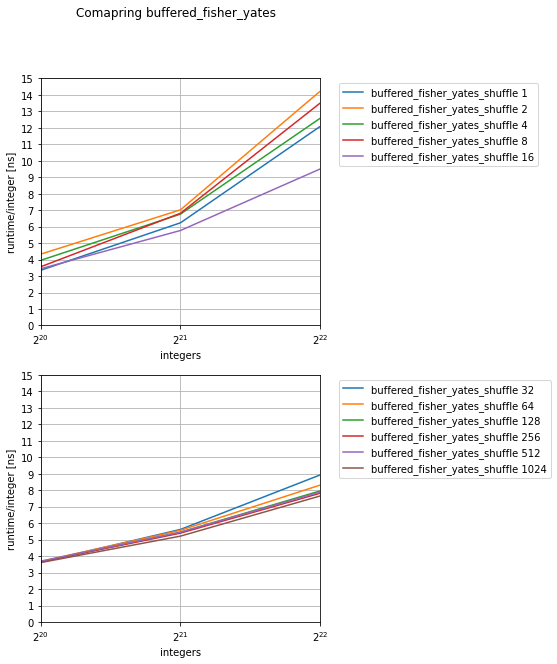

In [7]:
# We plot data
ax_xticks = [2 ** i for i in range(0, 31, 1)]
ax_yticks = [1 * i for i in range(0, 100, 1)]

half = int(len(dfs_buffered)/2)

fig, axes = plt.subplots(2, figsize=(5,10))

for i in range(0, half):
    dfs_buffered[i].plot(ax=axes[0], x="integers", y="runtime/integer [ns]", label=dfs_buffered[i]["function"][0] + " " + str(dfs_buffered[i]["buffer"][0]))

for i in range(half, len(dfs_buffered)):
    dfs_buffered[i].plot(ax=axes[1], x="integers", y="runtime/integer [ns]", label=dfs_buffered[i]["function"][0] + " " + str(dfs_buffered[i]["buffer"][0]))

for i in range(2):
    ax = axes[i]
    ax.set_xscale("log", base=2)
    # ax.set_yscale("log", base=10)
    ax.set_xticks(ax_xticks)
    ax.set_yticks(ax_yticks)
    ax.set_xlim(2**20, 2**22)
    ax.set_ylim(0, 15)
    ax.grid(True)
    ax.set_xlabel("integers")
    ax.set_ylabel("runtime/integer [ns]")
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

fig.suptitle("Comapring buffered_fisher_yates")

Lets compare some of this with the others

In [25]:
# Lets compare the other ones
df_std_shuffle = pd.read_csv(path.join("..", "cpp", "uni-machine", "v0.1.9", "base_case", "20231213-020409-nb=0-bf=0-th=0-cpp.csv"))
df_fy_shuffle_32 = pd.read_csv(path.join("..", "cpp", "uni-machine", "v0.1.9", "base_case", "20231213-021932-nb=0-bf=0-th=0-cpp.csv"))
df_buffered_dynamic = pd.read_csv(path.join("..", "cpp", "uni-machine", "v0.1.11", "buffered", "20231214-023431-nb=0-bf=256-th=0-cpp.csv"))

In [26]:
df_std_shuffle["runtime/integer [ns]"] = (df_std_shuffle["total_runtime"] / df_std_shuffle["total_runs"]) / df_std_shuffle["integers"]
df_fy_shuffle_32["runtime/integer [ns]"] = (df_fy_shuffle_32["total_runtime"] / df_fy_shuffle_32["total_runs"]) / df_fy_shuffle_32["integers"]
df_buffered_dynamic["runtime/integer [ns]"] = (df_buffered_dynamic["total_runtime"] / df_buffered_dynamic["total_runs"]) / df_buffered_dynamic["integers"]

Text(0.5, 1.0, 'Comapring some shhuffle algorithms for base case')

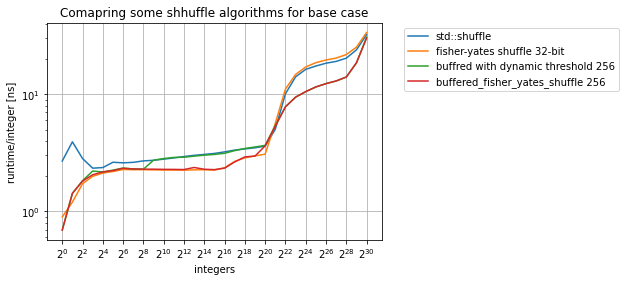

In [27]:
# We plot data
ax_xticks = [2 ** i for i in range(0, 31, 2)]
ax_yticks = [1 * i for i in range(0, 50, 1)]

ax = df_std_shuffle.plot(x="integers", y="runtime/integer [ns]", label="std::shuffle")
df_fy_shuffle_32.plot(ax=ax, x="integers", y="runtime/integer [ns]", label="fisher-yates shuffle 32-bit")
df_buffered_dynamic.plot(ax=ax, x="integers", y="runtime/integer [ns]", label="buffred with dynamic threshold 256")
# dfs_buffered[7].plot(ax=ax, x="integers", y="runtime/integer [ns]", label=dfs_buffered[8]["function"][7] + " " + str(dfs_buffered[7]["buffer"][0]))
dfs_buffered[8].plot(ax=ax, x="integers", y="runtime/integer [ns]", label=dfs_buffered[8]["function"][0] + " " + str(dfs_buffered[8]["buffer"][0]))
# dfs_buffered[10].plot(ax=ax, x="integers", y="runtime/integer [ns]", label=dfs_buffered[10]["function"][0] + " " + str(dfs_buffered[10]["buffer"][0]))

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(ax_xticks)
# ax.set_yticks(ax_yticks)
# ax.set_xlim(2**20, 2**22)
# ax.set_ylim(0, 50)
ax.grid(True)
ax.set_xlabel("integers")
ax.set_ylabel("runtime/integer [ns]")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_title("Comapring some shhuffle algorithms for base case")